In [43]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

## Reading Univariate and Bivariate data first

In [44]:
path_univ = '/Group20/Regression/UnivariateData/20.csv'
path_biv = '/Group20/Regression/BivariateData/20.csv'

In [45]:
df_univ = pd.read_csv(os.getcwd() + path_univ, header=None)
df_biv = pd.read_csv(os.getcwd() + path_biv, header=None)
print(df_univ.head())
print(df_biv.head())


       0       1
0  0.962  2.9250
1  0.784  2.3300
2  0.992  3.0094
3  0.604  2.1534
4  0.066  1.9694
      0     1         2
0  0.46  1.00 -5.970800
1  0.07  0.20  3.331600
2  0.65  0.52 -3.442800
3  0.21  0.52 -0.001112
4  0.22  1.00 -1.201900


## Train-test-validation split

In [46]:
def train_test_valid_split(df):
    df = df.sample(frac=1).reset_index(drop=True)  
    train = df.iloc[: int(0.6*len(df)), :]
    validation = df.iloc[int(0.6*len(df)): int(0.8*len(df)), :]
    test = df.iloc[int(0.8*len(df)): , :]
    return train, validation, test

In [47]:
univ_train, univ_valid, univ_test = train_test_valid_split(df_univ)
print(univ_train.shape, univ_valid.shape, univ_test.shape)
# bivariate
biv_train, biv_valid, biv_test = train_test_valid_split(df_biv)
print(biv_train.shape, biv_valid.shape, biv_test.shape)

(600, 2) (200, 2) (201, 2)
(6120, 3) (2040, 3) (2041, 3)


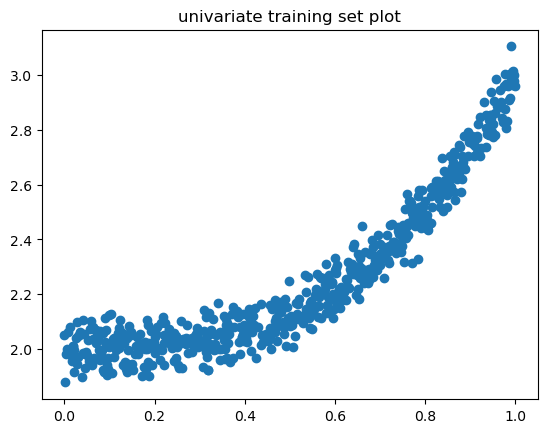

In [48]:
# separating ground truth and inputs for univariate case
x_train_univ, y_train_univ = univ_train.iloc[:,:1].values, univ_train.iloc[:,1].values 
x_valid_univ, y_valid_univ = univ_valid.iloc[:,:1].values, univ_valid.iloc[:,1].values
x_test_univ, y_test_univ = univ_test.iloc[:,:1].values, univ_test.iloc[:,1].values
plt.scatter(x_train_univ, y_train_univ)
plt.title('univariate training set plot')
plt.show()

In [49]:
x_train_univ.shape

(600, 1)

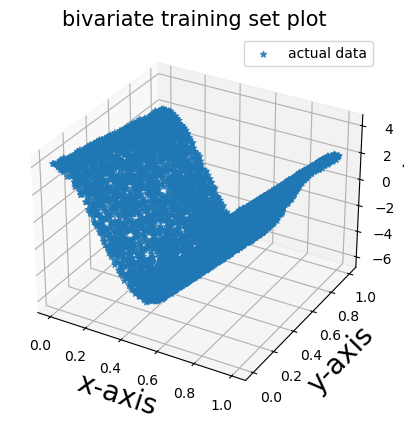

In [50]:
# separating ground truth and inputs for bivariate case
x_train_biv, y_train_biv = biv_train.iloc[:,:2].values, biv_train.iloc[:,2].values 
x_valid_biv, y_valid_biv = biv_valid.iloc[:,:2].values, biv_valid.iloc[:,2].values
x_test_biv, y_test_biv = biv_test.iloc[:,:2].values, biv_test.iloc[:,2].values
ax = plt.axes(projection='3d')
ax.scatter3D(x_train_biv[:,0],x_train_biv[:,1],y_train_biv, alpha=0.8,  marker='*', label='actual data')
ax.set_xlabel('x-axis', fontsize=20)
ax.set_ylabel('y-axis', fontsize=20)
ax.set_zlabel('z-axis', fontsize=20)
plt.title("bivariate training set plot", fontsize=15)
plt.legend()
plt.show()

---
## <center>Writing the Model for regression with user-defined hidden layers
---

In [51]:
# # bruteforcing for hidden layer1 and later we shall generalize
# inputs_ = 2
# hidden_layer = [3,4]
# output = 1
# #

In [52]:
# network_arch = ([inputs_] + hidden_layer + [output])
# print(network_arch)
# type(network_arch)


In [53]:
# weight_matrix = [] #list of matrices
# bias_matrix = [] # list of bias matrix or bias vector
# mu, sigma = 0, 1 # mean and standard deviation of normal distribution

# for l in range(len(network_arch)-1):
#     w_i = np.random.normal(mu, sigma, (network_arch[l],network_arch[l+1]))
#     b_i = np.random.normal(mu, sigma, (network_arch[l+1],1))
#     weight_matrix.append(w_i)
#     bias_matrix.append(b_i)

# print(weight_matrix)
# print('corresponding biases')
# print(bias_matrix)

In [54]:
#Activation functions and their derivatives
#logistic function
def logistic_fun(x):
    return 1/(1 + np.exp(-x))
def deriv_logistic_fun(x):
    return logistic_fun(x)*(1 - logistic_fun(x))

# Hyberbolic Tangent Function
def tanh(x):
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))
def deriv_tanh(x):
    return (1 - np.square(tanh(x)))

# Linear Activation 
def linear_fun(x):
    return x
def deriv_linear_fun(x):
    return 1


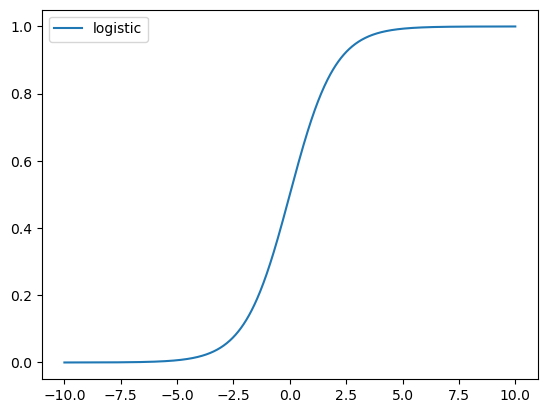

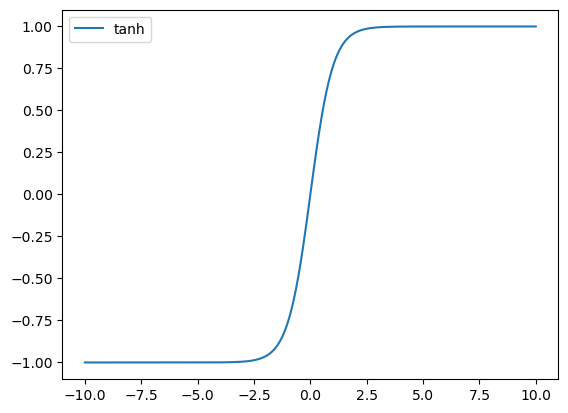

In [55]:
nums = np.linspace(-10,10, 1000)
plt.plot(nums, logistic_fun(nums), label='logistic')
plt.legend()
plt.show()
plt.plot(nums, tanh(nums), label='tanh')
plt.legend()
plt.show()

In [56]:
#perform forward computation for randomly generated parameters
def forward_computation(example, weight_matrix, bias_matrix):
    # The activation values in each layer of forward computation needs to be stored. 
    # As we'll need it in backpropagation step. It should be 2D numpy array.
    
    y_pred = example.reshape(-1,1)
    activations = [y_pred] 
    for i in range(len(weight_matrix)):
        y_pred = np.matmul(weight_matrix[i].T,y_pred) + bias_matrix[i]
        activations.append(y_pred)
        # activation step
        if i != len(weight_matrix) - 1:
            y_pred = logistic_fun(y_pred) # in regression output layer has linear activation function
        
#         print(y_pred, "iteration{}".format(i))
    return y_pred, activations
                           
        
        


In [57]:
# backpropagation would be done in two steps
# 1. calculation of delta values
# 2. updation of weight and biase using delta

#This backpropagation is customised only for regression.
def backpropagation(y_pred, y_act, activation_values, weights_matrix, bias_matrix, lr = 0.001):
    # make y_pred and y_act of same dimension
    y_act = np.array(y_act).reshape(-1,1)
    correction_values = []
    
    # as the name suggest we need to propagate the error in backward direction
    del_out = (y_act - y_pred) # dE_dw for last layer 
    w_size = len(weights_matrix)
    for i in range(w_size):
        if i != 0 :
            del_out = np.matmul(weights_matrix[w_size - i], del_out)*(deriv_logistic_fun(activation_values[w_size - i]))
        del_b_out = del_out*lr # bias correction factor
        if i != w_size - 1:
            del_w_out = np.matmul(logistic_fun(activation_values[w_size - 1 - i]), del_out.T)*lr
        else: #if i == w_size - 1:
            del_w_out = np.matmul(activation_values[w_size - 1 - i], del_out.T)*lr # weight correction factor
        # store the correction values of each layer
        correction_values.append([del_w_out, del_b_out])
#     for x in correction_values:
#         print("****************** layer last to 1")
#         print(x[0].shape)
#         print(x[1].shape)
    # Step:2 Update weights
    for i in range(len(correction_values)):
        weights_matrix[i] += correction_values[len(correction_values) - i - 1][0]
        bias_matrix[i] += correction_values[len(correction_values) - i - 1][1]
    return weights_matrix, bias_matrix
        
            
        
        
    
    


---
## <center>Combining all the functions above, writing a regression function
### <center>We'll make a module/(OOPs implementation of regression) later
---

In [58]:
def fit_regressor(inputs_: int, hidden_layer : list, output: int, x_train, y_train,  epochs: int, lr = 0.001):
    # x_valid, y_valid,
    #1. Initialization Step
    network_arch = ([inputs_] + hidden_layer + [output])
    weight_matrix = [] #list of matrices
    bias_matrix = [] # list of bias matrix or bias vector
    mu, sigma = 0, 1 # mean and standard deviation of normal distribution

    for l in range(len(network_arch)-1):
        w_i = np.random.normal(mu, sigma, (network_arch[l],network_arch[l+1]))
        b_i = np.random.normal(mu, sigma, (network_arch[l+1],1))
        weight_matrix.append(w_i)
        bias_matrix.append(b_i)
    
    #2. 
    prev_epoch_err = np.inf
    squarred_avg_err = [] # stores average MSE of each epoch
    for epoch in range(epochs):
        np.random.seed(123)
        # generate a random permutation of the indices
        idx = np.random.permutation(len(x_train))
        
        # shuffle the arrays using the same indices
        x_train = x_train[idx]
        y_train = y_train[idx]
        
        epoch_err = 0
        for i in range(len(x_train)):
            #(a) do forward computation
            y_pred, layer_outputs = forward_computation(x_train[i], weight_matrix, bias_matrix)
            
            #(b) compute instantaneous error
            ins_err = np.sum(np.square(y_pred - y_train[i].reshape(-1,1)))/2 
            epoch_err += ins_err
            
            #(c) perform backpropagation and update weights
            weight_matrix, bias_matrix = backpropagation(y_pred, y_train[i], layer_outputs, weight_matrix, bias_matrix, lr)
        
        # checking for convergence criteria
        avg_epoch_err = epoch_err/len(x_train)
        squarred_avg_err.append(avg_epoch_err)
        if abs(prev_epoch_err - avg_epoch_err) < 0.00001:
            print(f'---------------- Convergance criteria has been satisfied ------- breaking execution loop at {epoch+1}th iteration -----')
            return {'weights': weight_matrix, "bias": bias_matrix, 'avg_err': squarred_avg_err}
        prev_epoch_err = avg_epoch_err
    return {'weights': weight_matrix, "bias": bias_matrix, 'avg_err': squarred_avg_err}
        


---
## <center>Let's use our Model to predict on validation and test data
---

In [59]:
def predict_one(example, weights, bias):
    y_pred, _ = forward_computation(example, weights, bias)
    return y_pred

def predict_many(x_inputs, weights, bias):
    y_preds = []
    for i in range(len(x_inputs)):
        y_preds.append(predict_one(x_inputs[i], weights, bias))
    y_preds = np.array(y_preds).reshape(-1,1)
    return y_preds

def MSE(y_actual, y_pred):
    y_actual = y_actual.reshape(-1,1)
    mean_squarred_error = np.sum(np.square(y_actual-y_pred))/len(y_actual)
    return mean_squarred_error

def RMSE(y_actual, y_pred):
    return np.sqrt(MSE(y_actual, y_pred))

In [60]:
def model_vs_actual(x_inputs, y_act, y_pred, title=""):
    plt.scatter(x_inputs, y_act, label='Actual Data',edgecolors='black')
    plt.scatter(x_inputs, y_pred, label='Model Output',edgecolors='black')
    plt.xlabel('x-axis')
    plt.ylabel('y-axis')
    plt.legend()
    plt.title(title)
    plt.show()
    return

## univariate Case with 1 and 2 Hidden Layers

---------------- Convergance criteria has been satisfied ------- breaking execution loop at 96th iteration -----


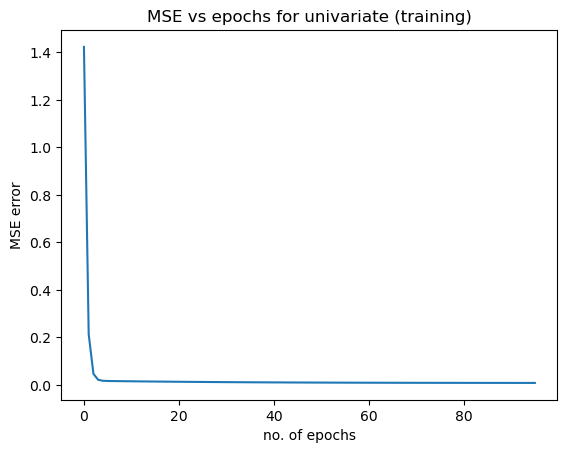

In [61]:
# checking our model for univariate case
fcnn1_univ = fit_regressor(1,[3], 1, x_train_univ, y_train_univ, 250)
err = fcnn1_univ['avg_err']
x_ = np.arange(len(err))
plt.plot(x_, err)
plt.title('MSE vs epochs for univariate (training)')
plt.xlabel('no. of epochs')
plt.ylabel('MSE error')
plt.show()

---------- Mean squarred Error for univariate ----------
0.016368469986144767
--------- Root Mean squarred Error for univariate  -----------
0.12793932150103332
--------------------


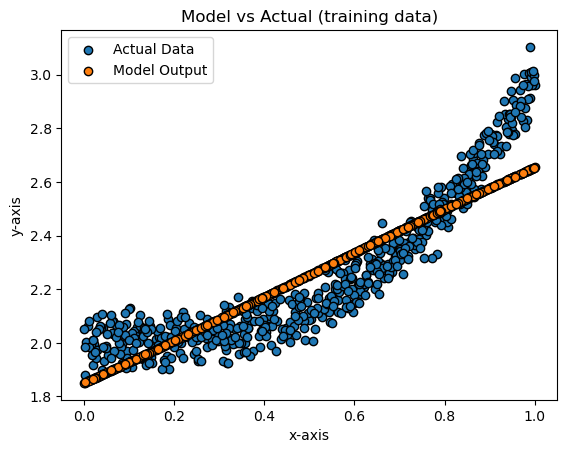

In [62]:
# train
pred1_univ = predict_many(x_train_univ, fcnn1_univ['weights'], fcnn1_univ['bias'])
mse = MSE(y_train_univ, pred1_univ)
rmse = RMSE(y_train_univ, pred1_univ)
print('---------- Mean squarred Error for univariate ----------')
print(mse)
print('--------- Root Mean squarred Error for univariate  -----------')
print(rmse)
print('--------------------')
model_vs_actual(x_train_univ, y_train_univ, pred1_univ, "Model vs Actual (training data)")


---------- Mean squarred Error for univariate ----------
0.017917208343763816
--------- Root Mean squarred Error for univariate  -----------
0.13385517675369832
--------------------


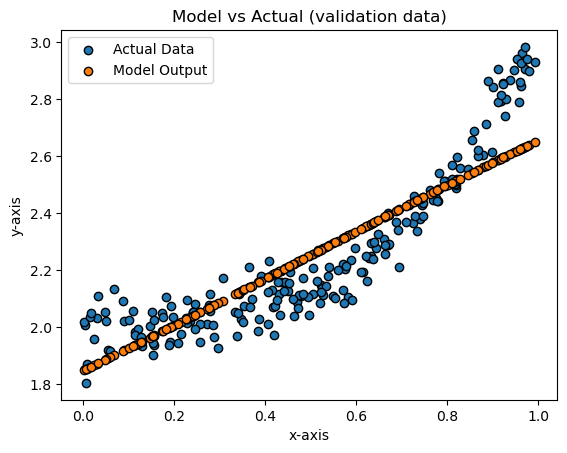

In [63]:
# validation data
pred1_univ = predict_many(x_valid_univ, fcnn1_univ['weights'], fcnn1_univ['bias'])
mse = MSE(y_valid_univ, pred1_univ)
rmse = RMSE(y_valid_univ, pred1_univ)
print('---------- Mean squarred Error for univariate ----------')
print(mse)
print('--------- Root Mean squarred Error for univariate  -----------')
print(rmse)
print('--------------------')
model_vs_actual(x_valid_univ, y_valid_univ, pred1_univ, "Model vs Actual (validation data)")


---------- Mean squarred Error for univariate ----------
0.014124319679893187
--------- Root Mean squarred Error for univariate  -----------
0.11884578107738275
--------------------


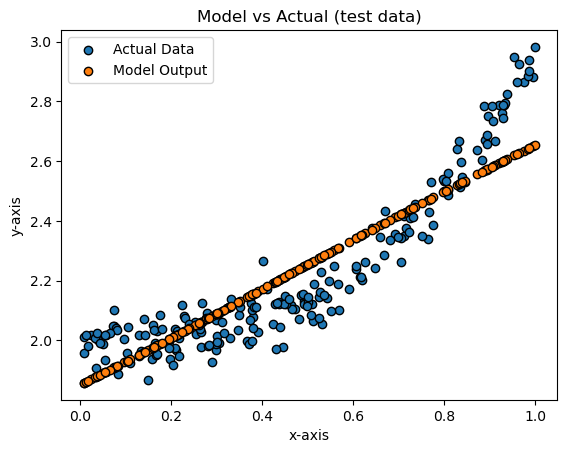

In [64]:
# test
pred1_univ = predict_many(x_test_univ, fcnn1_univ['weights'], fcnn1_univ['bias'])
mse = MSE(y_test_univ, pred1_univ)
rmse = RMSE(y_test_univ, pred1_univ)
print('---------- Mean squarred Error for univariate ----------')
print(mse)
print('--------- Root Mean squarred Error for univariate  -----------')
print(rmse)
print('--------------------')
model_vs_actual(x_test_univ, y_test_univ, pred1_univ, "Model vs Actual (test data)")


---------------- Convergance criteria has been satisfied ------- breaking execution loop at 79th iteration -----


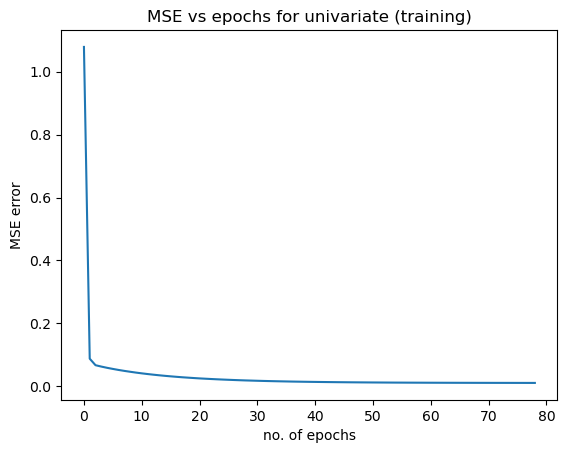

In [65]:
# checking our model for univariate case
fcnn2_univ = fit_regressor(1,[8], 1, x_train_univ, y_train_univ, 250)
err = fcnn2_univ['avg_err']
x_ = np.arange(len(err))
plt.plot(x_, err)
plt.title('MSE vs epochs for univariate (training)')
plt.xlabel('no. of epochs')
plt.ylabel('MSE error')
plt.show()

---------- Mean squarred Error for univariate ----------
0.021565086277984216
--------- Root Mean squarred Error for univariate  -----------
0.1468505576359321
--------------------


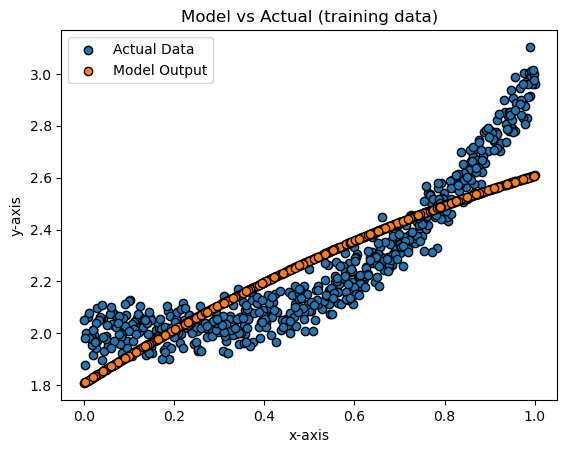

In [66]:
# train
pred1_univ = predict_many(x_train_univ, fcnn2_univ['weights'], fcnn2_univ['bias'])
mse = MSE(y_train_univ, pred1_univ)
rmse = RMSE(y_train_univ, pred1_univ)
print('---------- Mean squarred Error for univariate ----------')
print(mse)
print('--------- Root Mean squarred Error for univariate  -----------')
print(rmse)
print('--------------------')
model_vs_actual(x_train_univ, y_train_univ, pred1_univ, "Model vs Actual (training data)")


---------- Mean squarred Error for univariate ----------
0.02343167004840901
--------- Root Mean squarred Error for univariate  -----------
0.15307406719757927
--------------------


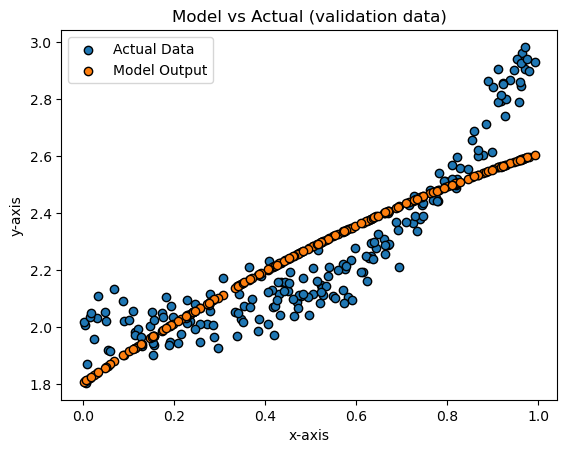

In [67]:
# validation data
pred1_univ = predict_many(x_valid_univ, fcnn2_univ['weights'], fcnn2_univ['bias'])
mse = MSE(y_valid_univ, pred1_univ)
rmse = RMSE(y_valid_univ, pred1_univ)
print('---------- Mean squarred Error for univariate ----------')
print(mse)
print('--------- Root Mean squarred Error for univariate  -----------')
print(rmse)
print('--------------------')
model_vs_actual(x_valid_univ, y_valid_univ, pred1_univ, "Model vs Actual (validation data)")


---------- Mean squarred Error for univariate ----------
0.019074991330057755
--------- Root Mean squarred Error for univariate  -----------
0.13811224178202944
--------------------


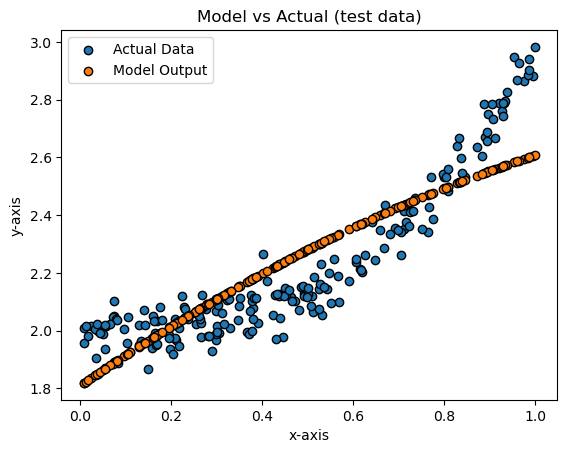

In [68]:
# test
pred1_univ = predict_many(x_test_univ, fcnn2_univ['weights'], fcnn2_univ['bias'])
mse = MSE(y_test_univ, pred1_univ)
rmse = RMSE(y_test_univ, pred1_univ)
print('---------- Mean squarred Error for univariate ----------')
print(mse)
print('--------- Root Mean squarred Error for univariate  -----------')
print(rmse)
print('--------------------')
model_vs_actual(x_test_univ, y_test_univ, pred1_univ, "Model vs Actual (test data)")


---------------- Convergance criteria has been satisfied ------- breaking execution loop at 176th iteration -----


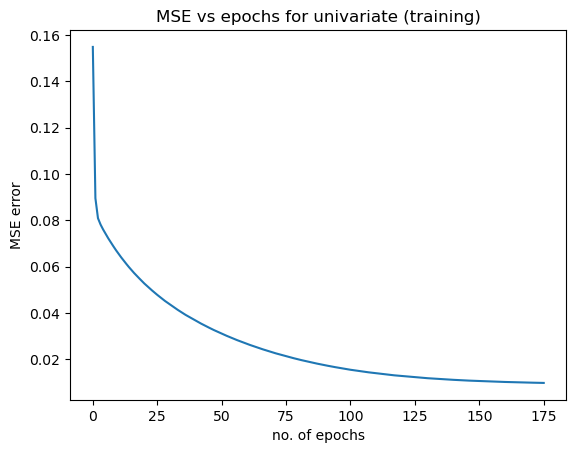

In [69]:
# checking our model for univariate case
fcnn3_univ = fit_regressor(1,[5], 1, x_train_univ, y_train_univ, 250)
err = fcnn3_univ['avg_err']
x_ = np.arange(len(err))
plt.plot(x_, err)
plt.title('MSE vs epochs for univariate (training)')
plt.xlabel('no. of epochs')
plt.ylabel('MSE error')
plt.show()

---------- Mean squarred Error for univariate ----------
0.019715077239279555
--------- Root Mean squarred Error for univariate  -----------
0.14041038864442887
--------------------


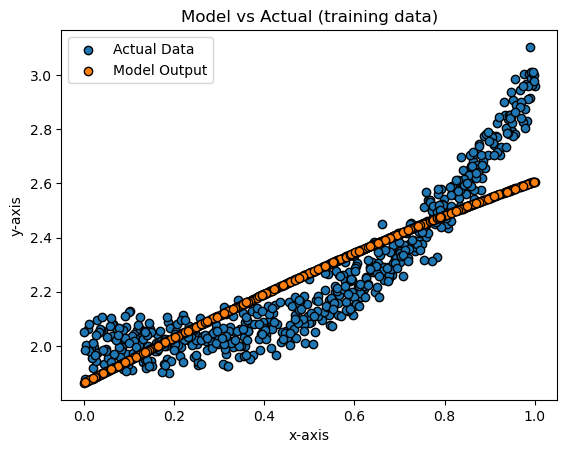

In [70]:
# train
pred1_univ = predict_many(x_train_univ, fcnn3_univ['weights'], fcnn3_univ['bias'])
mse = MSE(y_train_univ, pred1_univ)
rmse = RMSE(y_train_univ, pred1_univ)
print('---------- Mean squarred Error for univariate ----------')
print(mse)
print('--------- Root Mean squarred Error for univariate  -----------')
print(rmse)
print('--------------------')
model_vs_actual(x_train_univ, y_train_univ, pred1_univ, "Model vs Actual (training data)")


---------- Mean squarred Error for univariate ----------
0.021699566966846665
--------- Root Mean squarred Error for univariate  -----------
0.14730772880893475
--------------------


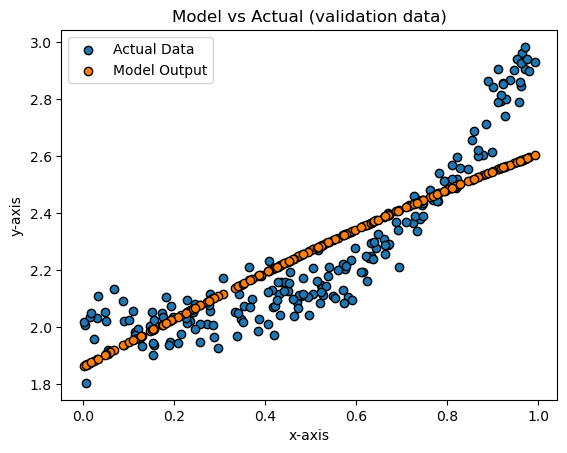

In [71]:
# validation data
pred1_univ = predict_many(x_valid_univ, fcnn3_univ['weights'], fcnn3_univ['bias'])
mse = MSE(y_valid_univ, pred1_univ)
rmse = RMSE(y_valid_univ, pred1_univ)
print('---------- Mean squarred Error for univariate ----------')
print(mse)
print('--------- Root Mean squarred Error for univariate  -----------')
print(rmse)
print('--------------------')
model_vs_actual(x_valid_univ, y_valid_univ, pred1_univ, "Model vs Actual (validation data)")


---------- Mean squarred Error for univariate ----------
0.017368049255447417
--------- Root Mean squarred Error for univariate  -----------
0.1317878949503611
--------------------


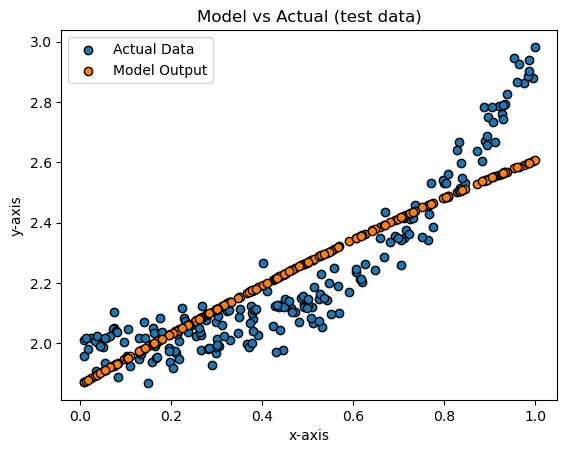

In [72]:
# test
pred1_univ = predict_many(x_test_univ, fcnn3_univ['weights'], fcnn3_univ['bias'])
mse = MSE(y_test_univ, pred1_univ)
rmse = RMSE(y_test_univ, pred1_univ)
print('---------- Mean squarred Error for univariate ----------')
print(mse)
print('--------- Root Mean squarred Error for univariate  -----------')
print(rmse)
print('--------------------')
model_vs_actual(x_test_univ, y_test_univ, pred1_univ, "Model vs Actual (test data)")


---------- Mean squarred Error for univariate ----------
0.017917208343763816
--------- Root Mean squarred Error for univariate  -----------
0.13385517675369832
--------------------


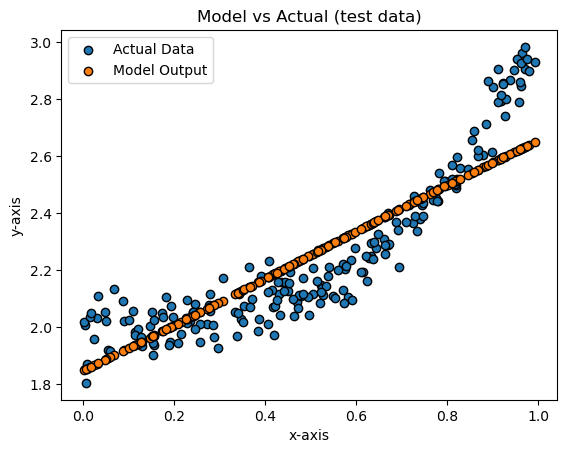

In [73]:
# validation data
pred1_univ = predict_many(x_valid_univ, fcnn1_univ['weights'], fcnn1_univ['bias'])
mse = MSE(y_valid_univ, pred1_univ)
rmse = RMSE(y_valid_univ, pred1_univ)
print('---------- Mean squarred Error for univariate ----------')
print(mse)
print('--------- Root Mean squarred Error for univariate  -----------')
print(rmse)
print('--------------------')
model_vs_actual(x_valid_univ, y_valid_univ, pred1_univ, "Model vs Actual (test data)")


---
    Univariate case with 2 Hidden layer
---

---------------- Convergance criteria has been satisfied ------- breaking execution loop at 58th iteration -----


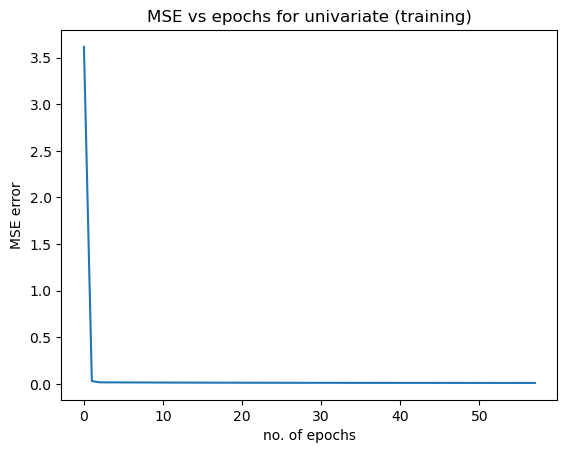

In [74]:
# checking our model for univariate case
fcnn4_univ = fit_regressor(1,[14,8], 1, x_train_univ, y_train_univ, 250)
err = fcnn4_univ['avg_err']
x_ = np.arange(len(err))
plt.plot(x_, err)
plt.title('MSE vs epochs for univariate (training)')
plt.xlabel('no. of epochs')
plt.ylabel('MSE error')
plt.show()

---------- Mean squarred Error for univariate ----------
0.023369442540445227
--------- Root Mean squarred Error for univariate  -----------
0.15287067259760856
--------------------


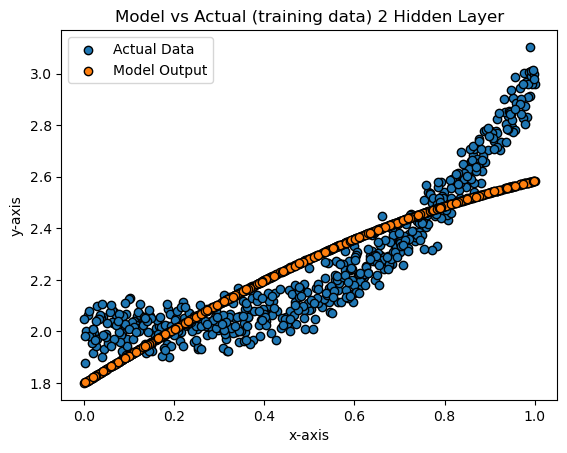

In [75]:
# train
pred1_univ = predict_many(x_train_univ, fcnn4_univ['weights'], fcnn4_univ['bias'])
mse = MSE(y_train_univ, pred1_univ)
rmse = RMSE(y_train_univ, pred1_univ)
print('---------- Mean squarred Error for univariate ----------')
print(mse)
print('--------- Root Mean squarred Error for univariate  -----------')
print(rmse)
print('--------------------')
model_vs_actual(x_train_univ, y_train_univ, pred1_univ, "Model vs Actual (training data) 2 Hidden Layer")


---------- Mean squarred Error for univariate ----------
0.025346118775498354
--------- Root Mean squarred Error for univariate  -----------
0.15920464432766512
--------------------


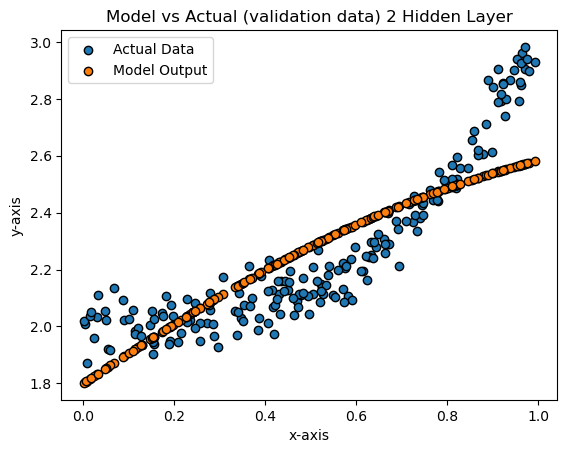

In [76]:
# validation data
pred1_univ = predict_many(x_valid_univ, fcnn4_univ['weights'], fcnn4_univ['bias'])
mse = MSE(y_valid_univ, pred1_univ)
rmse = RMSE(y_valid_univ, pred1_univ)
print('---------- Mean squarred Error for univariate ----------')
print(mse)
print('--------- Root Mean squarred Error for univariate  -----------')
print(rmse)
print('--------------------')
model_vs_actual(x_valid_univ, y_valid_univ, pred1_univ, "Model vs Actual (validation data) 2 Hidden Layer")


---------- Mean squarred Error for univariate ----------
0.02066304689159423
--------- Root Mean squarred Error for univariate  -----------
0.14374646740561742
--------------------


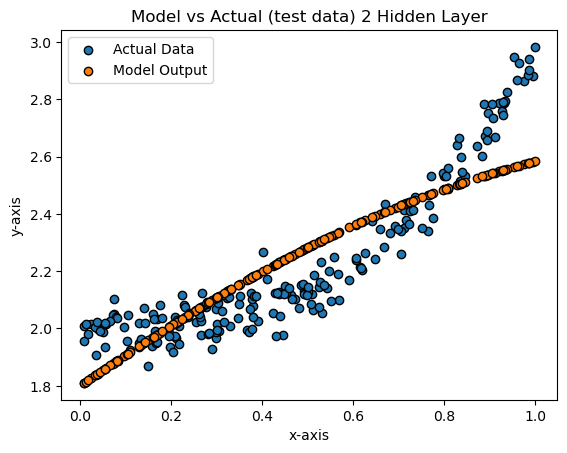

In [77]:
# test
pred1_univ = predict_many(x_test_univ, fcnn4_univ['weights'], fcnn4_univ['bias'])
mse = MSE(y_test_univ, pred1_univ)
rmse = RMSE(y_test_univ, pred1_univ)
print('---------- Mean squarred Error for univariate ----------')
print(mse)
print('--------- Root Mean squarred Error for univariate  -----------')
print(rmse)
print('--------------------')
model_vs_actual(x_test_univ, y_test_univ, pred1_univ, "Model vs Actual (test data) 2 Hidden Layer")


## Bivariate Case with 1 and 2 Hidden Layers

In [78]:
def plot3d_model_actual(x_inputs, y_act, y_pred, title=''):
    ax = plt.axes(projection='3d')
    ax.scatter3D(x_inputs[:,0],x_inputs[:,1],y_act, alpha=0.8,  marker='*', label='Actual Data')
    ax.scatter3D(x_inputs[:,0],x_inputs[:,1],y_pred, alpha=0.8,  marker='*', label='Model Output')
    ax.set_xlabel('x-axis', fontsize=20)
    ax.set_ylabel('y-axis', fontsize=20)
    ax.set_zlabel('z-axis', fontsize=20)
    plt.title(title, fontsize=15)
    plt.legend()
    plt.show()
    return

---------------- Convergance criteria has been satisfied ------- breaking execution loop at 45th iteration -----


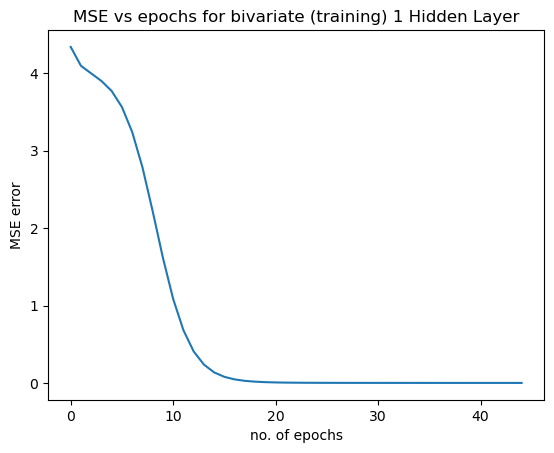

In [79]:
# checking our model for bivariate case
fcnn1_biv = fit_regressor(2,[15], 1, x_train_biv, y_train_biv, 250)
err = fcnn1_biv['avg_err']
x_ = np.arange(len(err))
plt.plot(x_, err)
plt.title('MSE vs epochs for bivariate (training) 1 Hidden Layer')
plt.xlabel('no. of epochs')
plt.ylabel('MSE error')
plt.show()

---------- Mean squarred Error for bivariate ----------
0.00746550523645341
--------- Root Mean squarred Error for bivariate  -----------
0.08640315524593653
--------------------


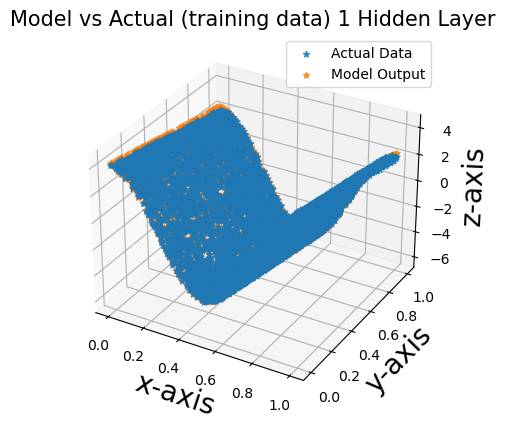

In [80]:
# train
pred1_biv = predict_many(x_train_biv, fcnn1_biv['weights'], fcnn1_biv['bias'])
mse = MSE(y_train_biv, pred1_biv)
rmse = RMSE(y_train_biv, pred1_biv)
print('---------- Mean squarred Error for bivariate ----------')
print(mse)
print('--------- Root Mean squarred Error for bivariate  -----------')
print(rmse)
print('--------------------')
plot3d_model_actual(x_train_biv, y_train_biv, pred1_biv, "Model vs Actual (training data) 1 Hidden Layer")


---------- Mean squarred Error for bivariate ----------
0.007038500982454481
--------- Root Mean squarred Error for bivariate  -----------
0.08389577452085702
--------------------


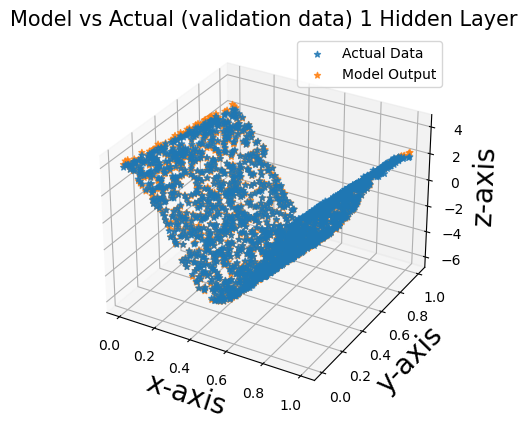

In [81]:
# validation
pred1_biv = predict_many(x_valid_biv, fcnn1_biv['weights'], fcnn1_biv['bias'])
mse = MSE(y_valid_biv, pred1_biv)
rmse = RMSE(y_valid_biv, pred1_biv)
print('---------- Mean squarred Error for bivariate ----------')
print(mse)
print('--------- Root Mean squarred Error for bivariate  -----------')
print(rmse)
print('--------------------')
plot3d_model_actual(x_valid_biv, y_valid_biv, pred1_biv, "Model vs Actual (validation data) 1 Hidden Layer")


---------- Mean squarred Error for bivariate ----------
0.007144002556105226
--------- Root Mean squarred Error for bivariate  -----------
0.08452220155737324
--------------------


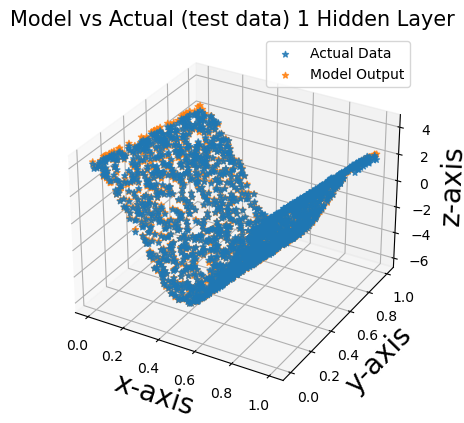

In [82]:
# test
pred1_biv = predict_many(x_test_biv, fcnn1_biv['weights'], fcnn1_biv['bias'])
mse = MSE(y_test_biv, pred1_biv)
rmse = RMSE(y_test_biv, pred1_biv)
print('---------- Mean squarred Error for bivariate ----------')
print(mse)
print('--------- Root Mean squarred Error for bivariate  -----------')
print(rmse)
print('--------------------')
plot3d_model_actual(x_test_biv, y_test_biv, pred1_biv, "Model vs Actual (test data) 1 Hidden Layer")


---------------- Convergance criteria has been satisfied ------- breaking execution loop at 72th iteration -----


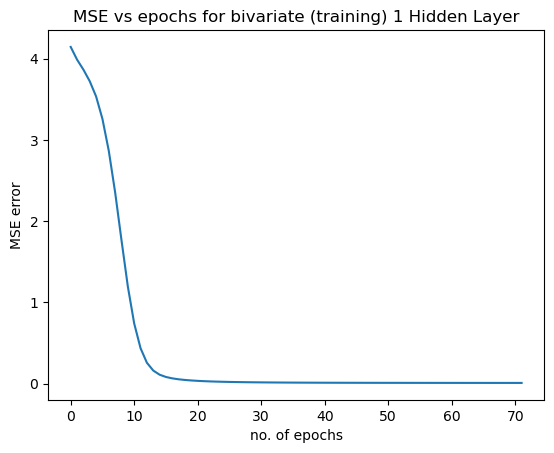

In [83]:
# checking our model for bivariate case
fcnn2_biv = fit_regressor(2,[18], 1, x_train_biv, y_train_biv, 250)
err = fcnn2_biv['avg_err']
x_ = np.arange(len(err))
plt.plot(x_, err)
plt.title('MSE vs epochs for bivariate (training) 1 Hidden Layer')
plt.xlabel('no. of epochs')
plt.ylabel('MSE error')
plt.show()

---------- Mean squarred Error for bivariate ----------
0.017564438388705746
--------- Root Mean squarred Error for bivariate  -----------
0.132530895977903
--------------------


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (6120,) and arg 2 with shape (201,).

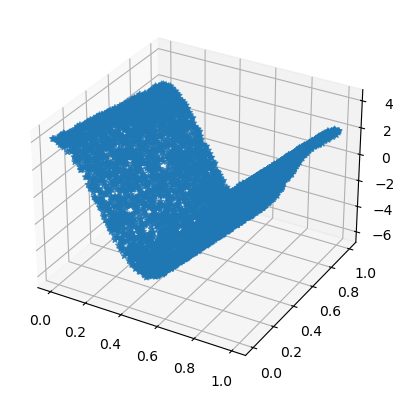

In [84]:
# train
pred1_biv = predict_many(x_train_biv, fcnn2_biv['weights'], fcnn2_biv['bias'])
mse = MSE(y_train_biv, pred1_biv)
rmse = RMSE(y_train_biv, pred1_biv)
print('---------- Mean squarred Error for bivariate ----------')
print(mse)
print('--------- Root Mean squarred Error for bivariate  -----------')
print(rmse)
print('--------------------')
plot3d_model_actual(x_train_biv, y_train_biv, pred1_univ, "Model vs Actual (training data) 1 Hidden Layer")


---------- Mean squarred Error for bivariate ----------
0.01709332373128863
--------- Root Mean squarred Error for bivariate  -----------
0.13074143846267192
--------------------


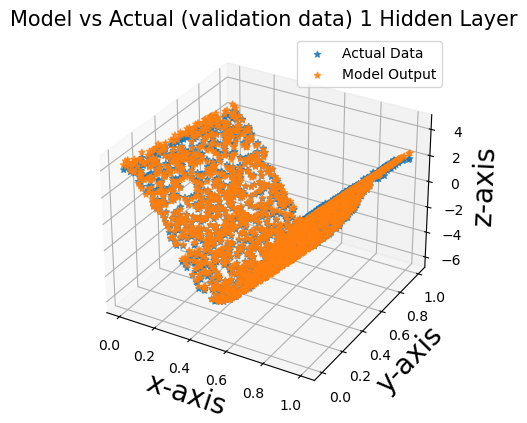

In [85]:
# validation
pred1_biv = predict_many(x_valid_biv, fcnn2_biv['weights'], fcnn2_biv['bias'])
mse = MSE(y_valid_biv, pred1_biv)
rmse = RMSE(y_valid_biv, pred1_biv)
print('---------- Mean squarred Error for bivariate ----------')
print(mse)
print('--------- Root Mean squarred Error for bivariate  -----------')
print(rmse)
print('--------------------')
plot3d_model_actual(x_valid_biv, y_valid_biv, pred1_biv, "Model vs Actual (validation data) 1 Hidden Layer")


---------- Mean squarred Error for bivariate ----------
0.017820732255938478
--------- Root Mean squarred Error for bivariate  -----------
0.13349431544428578
--------------------


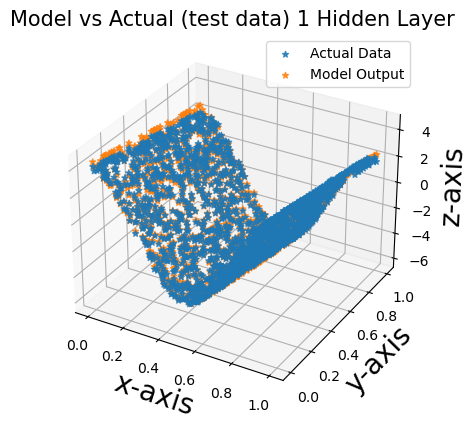

In [86]:
# test
pred1_biv = predict_many(x_test_biv, fcnn2_biv['weights'], fcnn2_biv['bias'])
mse = MSE(y_test_biv, pred1_biv)
rmse = RMSE(y_test_biv, pred1_biv)
print('---------- Mean squarred Error for bivariate ----------')
print(mse)
print('--------- Root Mean squarred Error for bivariate  -----------')
print(rmse)
print('--------------------')
plot3d_model_actual(x_test_biv, y_test_biv, pred1_biv, "Model vs Actual (test data) 1 Hidden Layer")


---
### With 2 Hidden Layer
---

---------------- Convergance criteria has been satisfied ------- breaking execution loop at 50th iteration -----


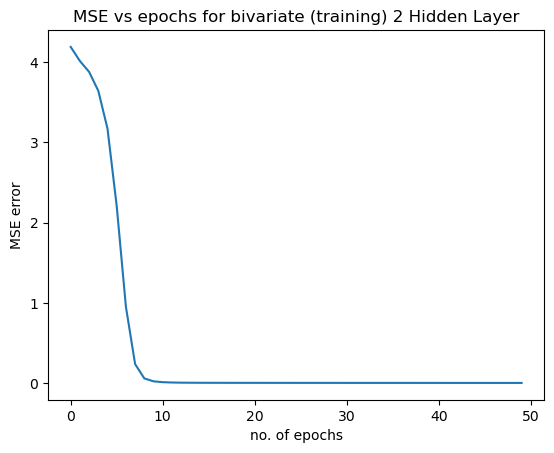

In [87]:
# checking our model for bivariate case
fcnn3_biv = fit_regressor(2,[15, 18], 1, x_train_biv, y_train_biv, 250)
err = fcnn3_biv['avg_err']
x_ = np.arange(len(err))
plt.plot(x_, err)
plt.title('MSE vs epochs for bivariate (training) 2 Hidden Layer')
plt.xlabel('no. of epochs')
plt.ylabel('MSE error')
plt.show()

---------- Mean squarred Error for bivariate ----------
0.009287171691882933
--------- Root Mean squarred Error for bivariate  -----------
0.09636997297853171
--------------------


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (6120,) and arg 2 with shape (201,).

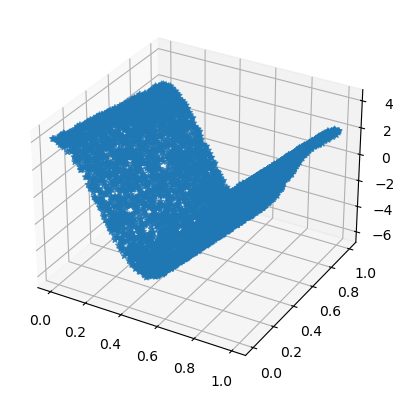

In [88]:
# train
pred1_biv = predict_many(x_train_biv, fcnn3_biv['weights'], fcnn3_biv['bias'])
mse = MSE(y_train_biv, pred1_biv)
rmse = RMSE(y_train_biv, pred1_biv)
print('---------- Mean squarred Error for bivariate ----------')
print(mse)
print('--------- Root Mean squarred Error for bivariate  -----------')
print(rmse)
print('--------------------')
plot3d_model_actual(x_train_biv, y_train_biv, pred1_univ, "Model vs Actual (training data) 2 Hidden Layer")


---------- Mean squarred Error for bivariate ----------
0.009430538969559253
--------- Root Mean squarred Error for bivariate  -----------
0.09711096214928186
--------------------


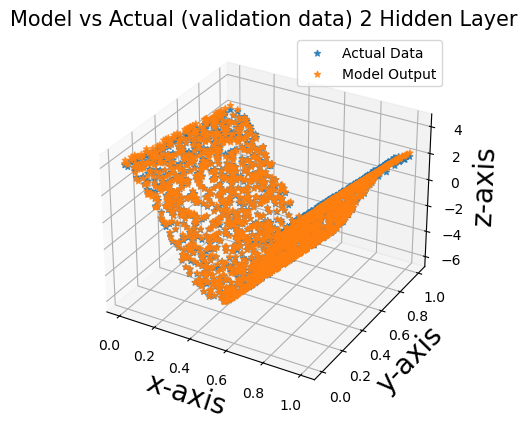

In [ ]:
# validation
pred1_biv = predict_many(x_valid_biv, fcnn3_biv['weights'], fcnn3_biv['bias'])
mse = MSE(y_valid_biv, pred1_biv)
rmse = RMSE(y_valid_biv, pred1_biv)
print('---------- Mean squarred Error for bivariate ----------')
print(mse)
print('--------- Root Mean squarred Error for bivariate  -----------')
print(rmse)
print('--------------------')
plot3d_model_actual(x_valid_biv, y_valid_biv, pred1_biv, "Model vs Actual (validation data) 2 Hidden Layer")


---------- Mean squarred Error for bivariate ----------
0.009224166607744059
--------- Root Mean squarred Error for bivariate  -----------
0.09604252499671205
--------------------


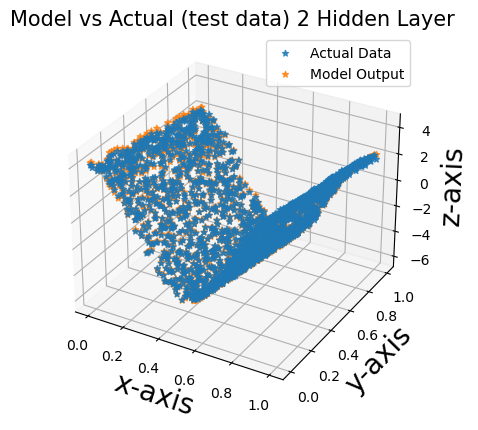

In [ ]:
# test
pred1_biv = predict_many(x_test_biv, fcnn3_biv['weights'], fcnn3_biv['bias'])
mse = MSE(y_test_biv, pred1_biv)
rmse = RMSE(y_test_biv, pred1_biv)
print('---------- Mean squarred Error for bivariate ----------')
print(mse)
print('--------- Root Mean squarred Error for bivariate  -----------')
print(rmse)
print('--------------------')
plot3d_model_actual(x_test_biv, y_test_biv, pred1_biv, "Model vs Actual (test data) 2 Hidden Layer")


  0%|          | 0/250 [00:00<?, ?it/s]

---------------- Convergance criteria has been satisfied ------- breaking execution loop at 42th iteration -----


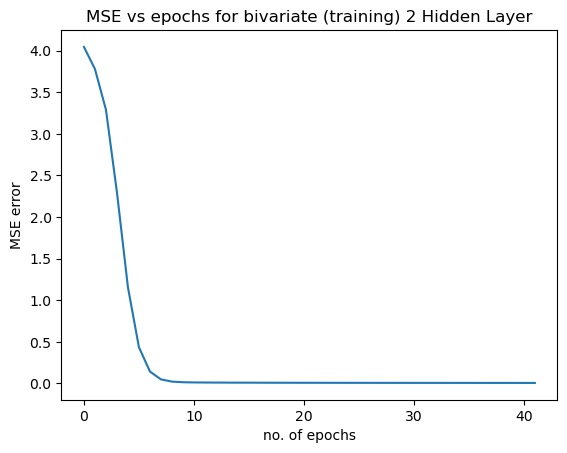

In [ ]:
# checking our model for bivariate case
fcnn4_biv = fit_regressor(2,[24, 17], 1, x_train_biv, y_train_biv, 250)
err = fcnn4_biv['avg_err']
x_ = np.arange(len(err))
plt.plot(x_, err)
plt.title('MSE vs epochs for bivariate (training) 2 Hidden Layer')
plt.xlabel('no. of epochs')
plt.ylabel('MSE error')
plt.show()

---------- Mean squarred Error for bivariate ----------
0.012088689565779267
--------- Root Mean squarred Error for bivariate  -----------
0.10994857691566211
--------------------


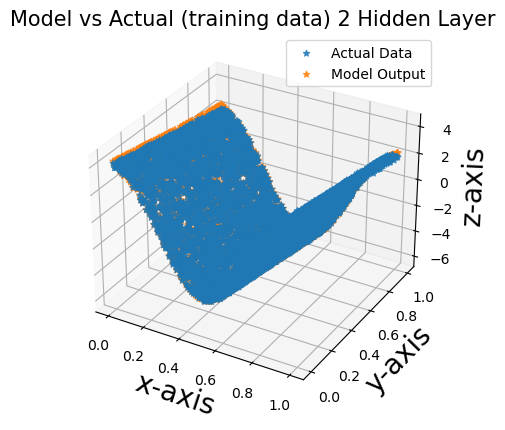

In [ ]:
# train
pred1_biv = predict_many(x_train_biv, fcnn4_biv['weights'], fcnn4_biv['bias'])
mse = MSE(y_train_biv, pred1_biv)
rmse = RMSE(y_train_biv, pred1_biv)
print('---------- Mean squarred Error for bivariate ----------')
print(mse)
print('--------- Root Mean squarred Error for bivariate  -----------')
print(rmse)
print('--------------------')
plot3d_model_actual(x_train_biv, y_train_biv, pred1_univ, "Model vs Actual (training data) 2 Hidden Layer")


---------- Mean squarred Error for bivariate ----------
0.011870384017077108
--------- Root Mean squarred Error for bivariate  -----------
0.10895129194771905
--------------------


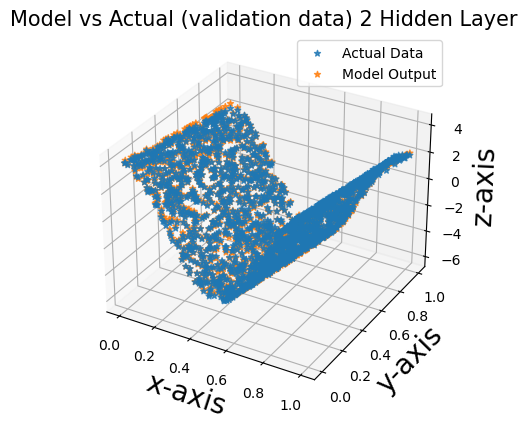

In [ ]:
# validation
pred1_biv = predict_many(x_valid_biv, fcnn4_biv['weights'], fcnn4_biv['bias'])
mse = MSE(y_valid_biv, pred1_biv)
rmse = RMSE(y_valid_biv, pred1_biv)
print('---------- Mean squarred Error for bivariate ----------')
print(mse)
print('--------- Root Mean squarred Error for bivariate  -----------')
print(rmse)
print('--------------------')
plot3d_model_actual(x_valid_biv, y_valid_biv, pred1_biv, "Model vs Actual (validation data) 2 Hidden Layer")


---------- Mean squarred Error for bivariate ----------
0.011933335996066033
--------- Root Mean squarred Error for bivariate  -----------
0.10923980957538343
--------------------


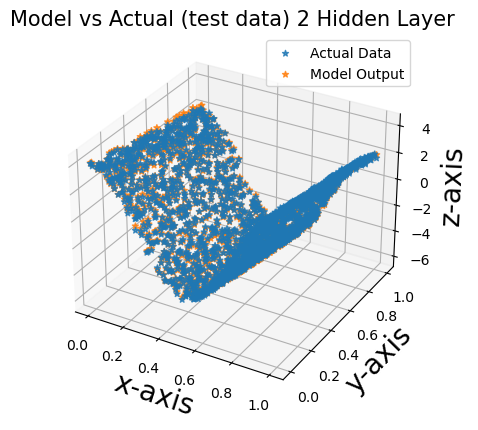

In [ ]:
# test
pred1_biv = predict_many(x_test_biv, fcnn4_biv['weights'], fcnn4_biv['bias'])
mse = MSE(y_test_biv, pred1_biv)
rmse = RMSE(y_test_biv, pred1_biv)
print('---------- Mean squarred Error for bivariate ----------')
print(mse)
print('--------- Root Mean squarred Error for bivariate  -----------')
print(rmse)
print('--------------------')
plot3d_model_actual(x_test_biv, y_test_biv, pred1_biv, "Model vs Actual (test data) 2 Hidden Layer")
